In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
# read the data and store data in DataFrame titled kn
df = pd.read_csv('../data/data.csv')

In [3]:
max_score = 5 * 32
score_students_columns = df.filter(regex='S$', axis=1)
final_score = score_students_columns.sum(axis=1)
grades = (final_score/max_score)*10
df['grade'] = grades
print(df.grade)

0        5.4375
1        3.3750
2        8.0625
3        9.0000
4        6.5000
          ...  
19213    6.7500
19214    4.2500
19215    6.1250
19216    6.3750
19217    4.2500
Name: grade, Length: 19218, dtype: float64


In [4]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df[['Q15S','Q25S','Q16S','Q19S','Q22S','Q23S','Q1S','Q9S','Q11S','Q27S']],
                                        df['grade'],
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = GradientBoostingRegressor(
            n_estimators = 10,
            loss         = 'ls',
            max_features = 'auto',
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

GradientBoostingRegressor(max_features='auto', n_estimators=10,
                          random_state=123)

In [5]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.9886213026383898


Valor óptimo de n_estimators: 326


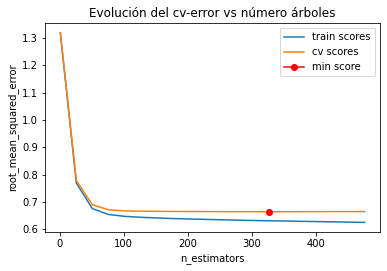

In [6]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 500, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = GradientBoostingRegressor(
                n_estimators = n_estimators,
                loss         = 'ls',
                max_features = 'auto',
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

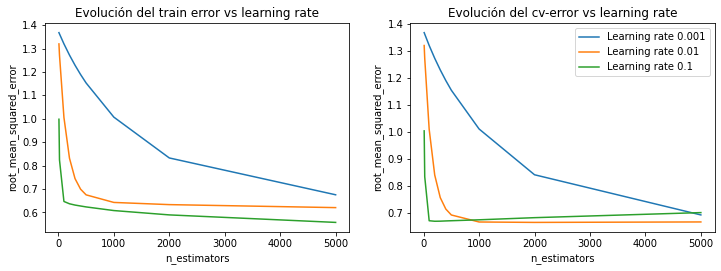

In [7]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
resultados = {}

# Valores evaluados
learning_rates = [0.001, 0.01, 0.1]
n_estimators   = [10, 20, 100, 200, 300, 400, 500, 1000, 2000, 5000]


# Bucle para entrenar un modelo con cada combinacion de  learning_rate y n_estimator 
# y extraer su error de entrenamiento y k-cross-validation.
for learning_rate in learning_rates:
    train_scores = []
    cv_scores    = []
    
    for n_estimator in n_estimators:
    
        modelo = GradientBoostingRegressor(
                    n_estimators  = n_estimator,
                    learning_rate = learning_rate,
                    loss          = 'ls',
                    max_features  = 'auto',
                    random_state  = 123
                 )

        # Error de train
        modelo.fit(X_train, y_train)
        predicciones = modelo.predict(X = X_train)
        rmse = mean_squared_error(
                y_true  = y_train,
                y_pred  = predicciones,
                squared = False
               )
        train_scores.append(rmse)

        # Error de validación cruzada
        scores = cross_val_score(
                    estimator = modelo,
                    X         = X_train,
                    y         = y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 3,
                    n_jobs    = multiprocessing.cpu_count() - 1
                 )
        # Se agregan los scores de cross_val_score() y se pasa a positivo
        cv_scores.append(-1*scores.mean())
        
    resultados[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

# Gráfico con la evolución de los errores de entrenamiento
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.84))

for key, value in resultados.items():
    axs[0].plot(n_estimators, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("Evolución del train error vs learning rate")
    
    axs[1].plot(n_estimators, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("Evolución del cv-error vs learning rate")
    plt.legend();

Valor óptimo de max_depth: 3


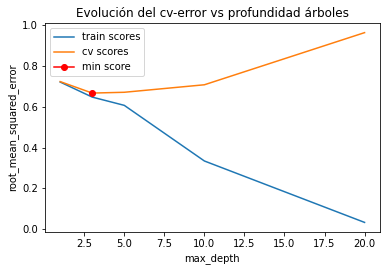

In [8]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_depths = [1, 3, 5, 10, 20]

# Bucle para entrenar un modelo con cada valor de max_depth y extraer su error
# de entrenamiento y de k-cross-validation.
for max_depth in max_depths:
    
    modelo = GradientBoostingRegressor(
                n_estimators = 100,
                loss         = 'ls',
                max_depth    = max_depth,
                max_features = 'auto',
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolución del cv-error vs profundidad árboles")
plt.legend();
print(f"Valor óptimo de max_depth: {max_depths[np.argmin(cv_scores)]}")

In [9]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = GradientBoostingRegressor(
                        n_estimators        = 1000, 
                        random_state        = 123,
                        # Activación de la parada temprana
                        validation_fraction = 0.1,
                        n_iter_no_change    = 5,
                        tol                 = 0.0001
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_max_depth,param_max_features,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
80,0.1,1,sqrt,0.5,-0.664560,0.005941,-0.659599,0.001455
82,0.1,1,log2,0.5,-0.664560,0.005941,-0.659599,0.001455
83,0.1,1,log2,1,-0.664803,0.006215,-0.659982,0.000759
81,0.1,1,sqrt,1,-0.664803,0.006215,-0.659982,0.000759


In [10]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 'sqrt', 'subsample': 0.5} : -0.66456036976962 neg_root_mean_squared_error


In [11]:
# Número de árboles del modelo final (early stopping)
# ==============================================================================
print(f"Número de árboles del modelo: {grid.best_estimator_.n_estimators_}")

Número de árboles del modelo: 267


In [12]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.6574194501218817


In [13]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df[['Q15S','Q25S','Q16S','Q19S','Q22S','Q23S','Q1S','Q9S','Q11S','Q27S']].columns,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,Q1S,0.186614
3,Q19S,0.149860
8,Q11S,0.124444
7,Q9S,0.114737
1,Q25S,0.093723
9,Q27S,0.088150
0,Q15S,0.082669
2,Q16S,0.060519
4,Q22S,0.059584
5,Q23S,0.039699


In [14]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
6,0.219771,0.002961,Q1S
3,0.126820,0.003406,Q19S
9,0.096889,0.001939,Q27S
8,0.084694,0.001509,Q11S
0,0.072705,0.001789,Q15S
7,0.069006,0.001259,Q9S
4,0.063521,0.001566,Q22S
2,0.057018,0.001724,Q16S
1,0.049179,0.000973,Q25S
5,0.033172,0.001580,Q23S


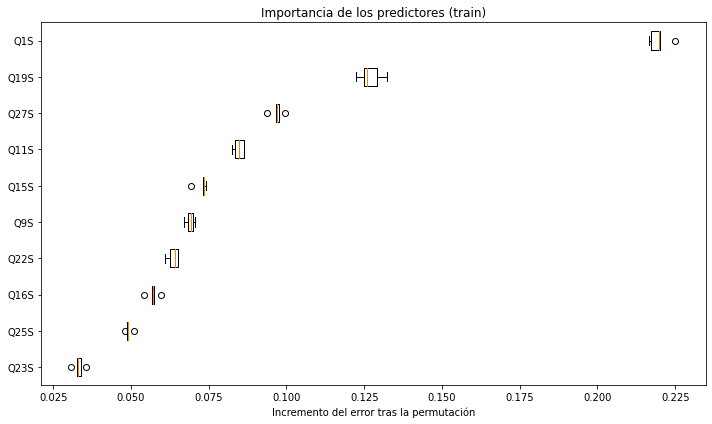

In [15]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))

sorted_idx = importancia.importances_mean.argsort()
ax.boxplot(
        importancia.importances[sorted_idx].T,
        vert   = False,
        labels = df[['Q15S','Q25S','Q16S','Q19S','Q22S','Q23S','Q1S','Q9S','Q11S','Q27S']].columns[sorted_idx]
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')
fig.tight_layout();

In [18]:
print(modelo_final.score(X_test, y_test))

0.7666275134006526
